In this study we are looking at 5 different varieties of rice grown in turkey.  They are Arborio, Basmati, Ipsala, Jasmine and Karacadag.  There are a total of 75,000 grain images, 15,000 from each variety are included in the dataset.   Our job is to use the Neural Network to correctly classify the type of rice, given the picture.

In [2]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import pathlib
import os

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

**Preparing the Data:**


Since we are given all the data at once, we need to separate our data into the training and validation sets.

In [3]:
tf.random.set_seed(1234)

train_data = keras.utils.image_dataset_from_directory('/kaggle/input/rice-image-dataset/Rice_Image_Dataset',
                                                 validation_split = 0.2,
                                                        subset = 'training',
                                                        seed = 1,
                                                        shuffle = True,
                                                        batch_size = 64,
                                                       image_size=(256,256))
test_data = keras.utils.image_dataset_from_directory('/kaggle/input/rice-image-dataset/Rice_Image_Dataset',
                                                       validation_split = 0.2,
                                                       subset = 'validation',
                                                       seed = 1,
                                                       shuffle = True,
                                                       batch_size = 64,
                                                    image_size=(256,256))

Found 75000 files belonging to 5 classes.
Using 60000 files for training.
Found 75000 files belonging to 5 classes.
Using 15000 files for validation.


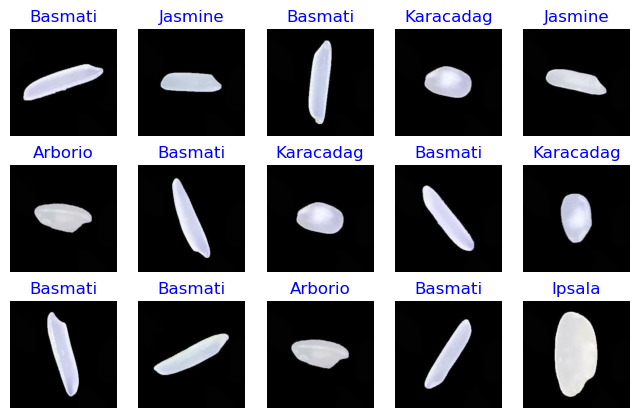

In [3]:
import random


# Print random images from the training data
plt.figure(figsize = (8, 5))
for images, labels in train_data.take(1):
    for i in range(15):
        index = random.randint(0, len(images) - 1)  # change this line
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[index].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[index]], color='blue', fontsize=12)
        plt.axis(False)
plt.show()

**Visualize RGB Distributions:**

You can plot histograms to see the distribution of R, G, and B values across the image.

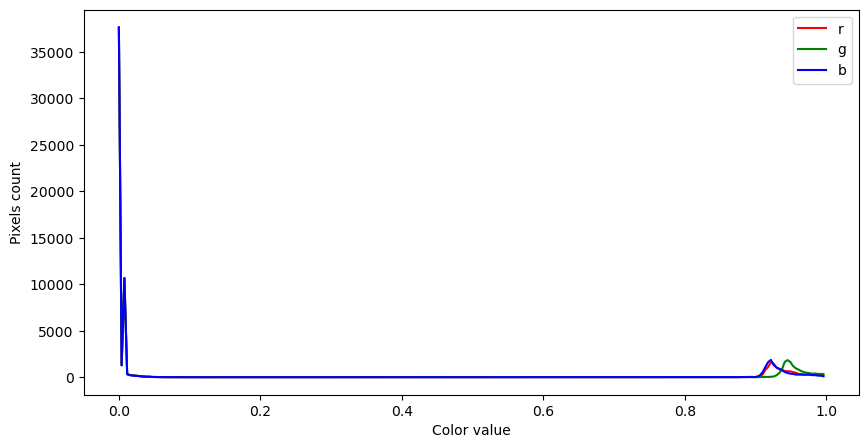

In [4]:
# Get the first batch of images and labels
images, labels = next(iter(train_data))

# Get the first image from the batch
image = images[0]

# Normalize the pixel values to be between 0 and 1
image = image / 255.0

# Plot a histogram of the red, green, and blue channels
plt.figure(figsize=(10, 5))
colors = ("r", "g", "b")

for i, color in enumerate(colors):
    histogram, bin_edges = np.histogram(image[..., i], bins=256, range=(0, 1))
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.xlabel("Color value")
plt.ylabel("Pixels count")
plt.legend(colors)
plt.show()

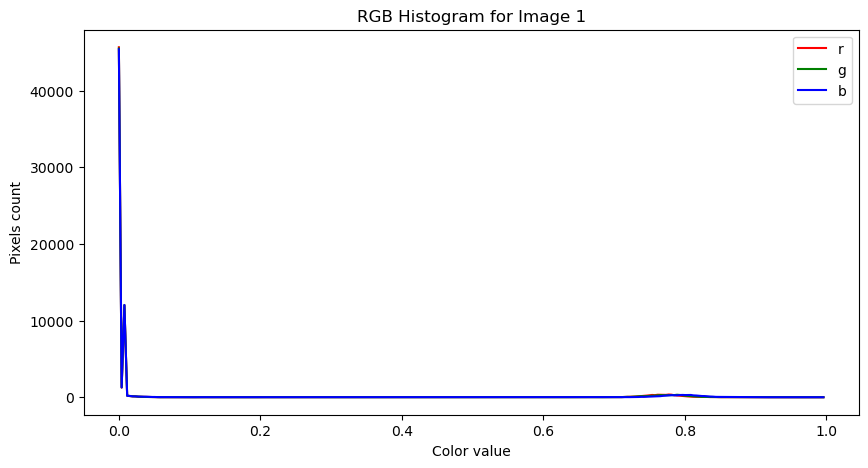

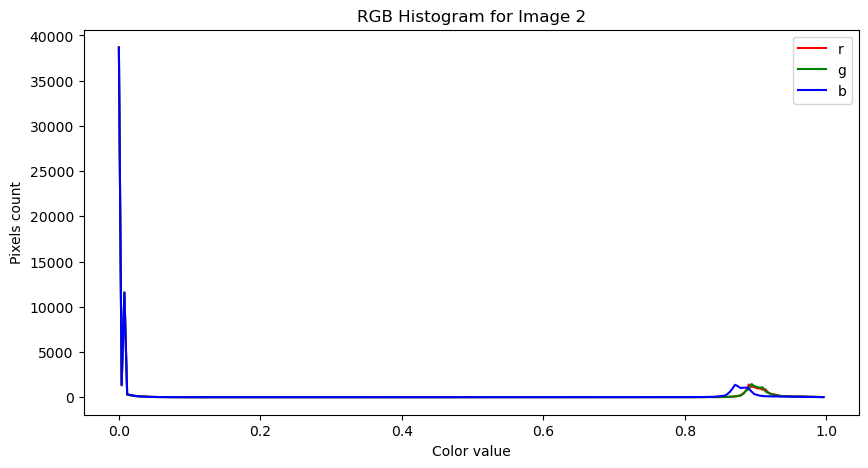

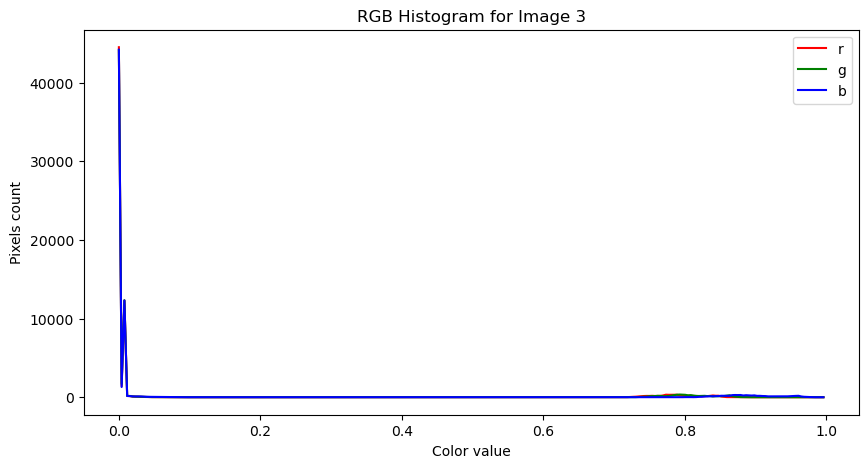

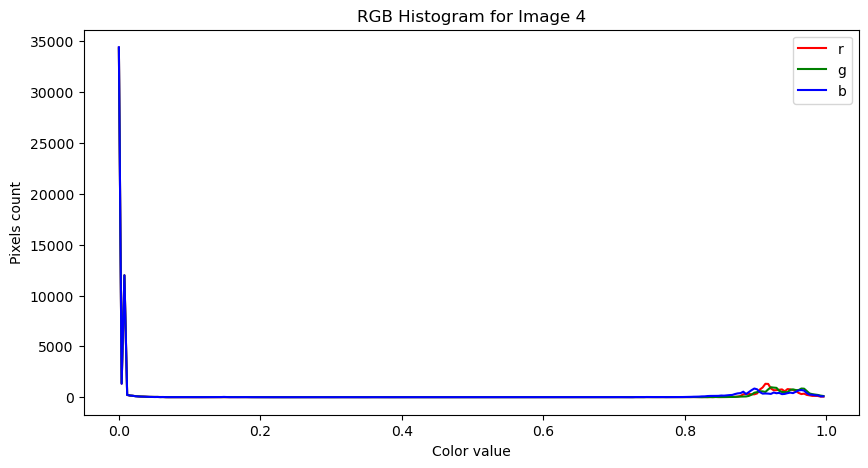

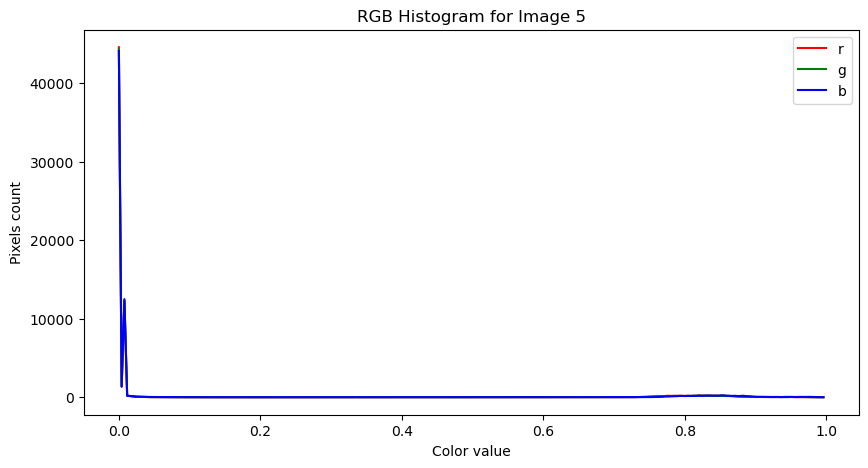

In [25]:
# Select the first few images
selected_images = images[:5]

# Normalize the pixel values to be between 0 and 1
selected_images = selected_images / 255.0

# Loop over selected images
for j, image in enumerate(selected_images):
    
    # Initialize the plot for each image
    plt.figure(figsize=(10, 5))
    colors = ("r", "g", "b")

    for i, color in enumerate(colors):
        histogram, bin_edges = np.histogram(image[..., i], bins=256, range=(0, 1))
        plt.plot(bin_edges[0:-1], histogram, color=color)

    # Show the plot for each image
    plt.xlabel("Color value")
    plt.ylabel("Pixels count")
    plt.legend(colors)
    plt.title(f'RGB Histogram for Image {j+1}')
    plt.show()

In [5]:
#Make sure all images are 256 by 256
# Iterate over the entire dataset
for images, labels in train_data:
    # Iterate over each image in the batch
    for image in images:
        # Check the shape of the image
        height, width, _ = image.shape
        if height != 256 or width != 256:
            print(f'Found an image with shape {image.shape}!')


In [6]:
filenames = pathlib.Path('/kaggle/input/rice-image-dataset/Rice_Image_Dataset')
for label in train_data.class_names :
    images = list(filenames.glob(f'{label}/*'))
    print(f'{label} : {len(images)}')

Arborio : 15000
Basmati : 15000
Ipsala : 15000
Jasmine : 15000
Karacadag : 15000


In [7]:
for images_batch, labels_batch in train_data:
    print(images_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


In [43]:
train_data.cardinality().numpy(),  test_data.cardinality().numpy() 

(938, 235)

In [4]:
training_set = train_data.take(700)
validation_set = train_data.skip(700)
#train dataset now has first 700 elements and the rest goes for validation_set

training_set.cardinality().numpy(),  validation_set.cardinality().numpy() 

(700, 238)

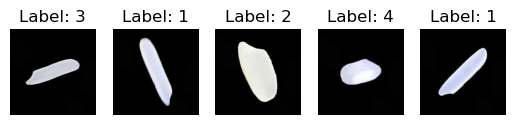

In [46]:
# Display the first 5 images in the validation set
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.show()

In this model:

The Rescaling layer is used to normalize pixel values (between 0 and 255) to the range 0-1.

The Conv2D layers are the convolution layers that will learn the features in your images.

The MaxPooling2D layers are used to downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window (also known as a pooling window) for each channel of the input.

The Flatten layer is used to convert the 3D outputs of the convolutional layers into 1D vectors, which can be used as input to the following dense layer.

The Dense layers are fully connected layers. The last Dense layer uses no activation function because this is a multi-class classification problem, and this layer will output the logits for each class. 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

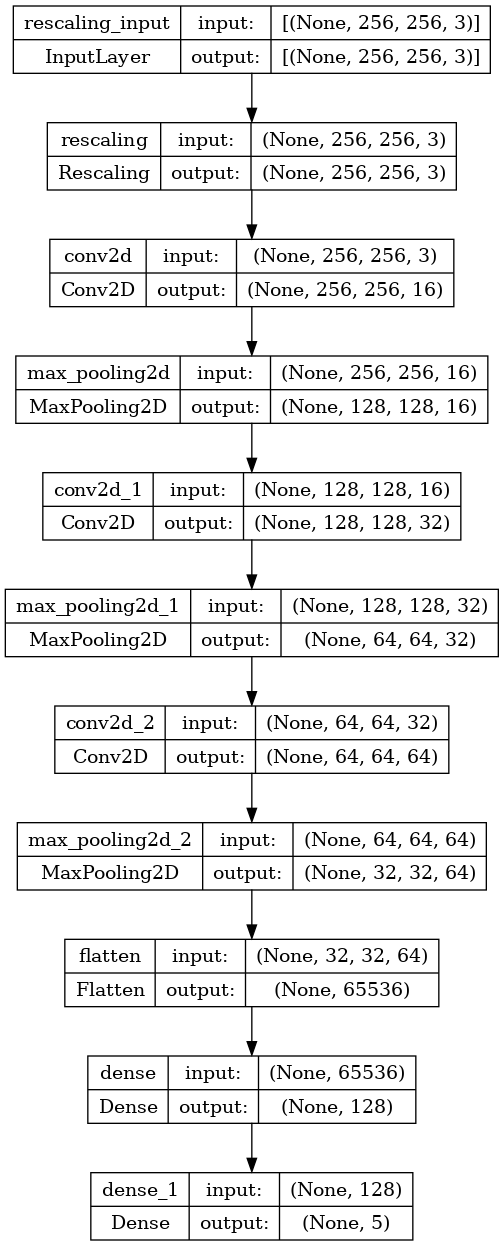

In [5]:
from tensorflow.keras import layers

model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5) # 5 because there are 5 classes
])
model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
history = model.fit(training_set, validation_data= validation_set, epochs=10)

Epoch 1/10
700/700 [==============================] - 326s 444ms/step - loss: 0.1163 - accuracy: 0.9616 - val_loss: 0.0638 - val_accuracy: 0.9803
Epoch 2/10
700/700 [==============================] - 220s 313ms/step - loss: 0.0359 - accuracy: 0.9879 - val_loss: 0.0195 - val_accuracy: 0.9937
Epoch 3/10
700/700 [==============================] - 198s 282ms/step - loss: 0.0313 - accuracy: 0.9899 - val_loss: 0.0259 - val_accuracy: 0.9909
Epoch 4/10
700/700 [==============================] - 180s 256ms/step - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.0397 - val_accuracy: 0.9862
Epoch 5/10
700/700 [==============================] - 195s 278ms/step - loss: 0.0216 - accuracy: 0.9933 - val_loss: 0.0424 - val_accuracy: 0.9865
Epoch 6/10
700/700 [==============================] - 176s 250ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.0162 - val_accuracy: 0.9946
Epoch 7/10
700/700 [==============================] - 161s 229ms/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 0.0571 -

(938, 235)

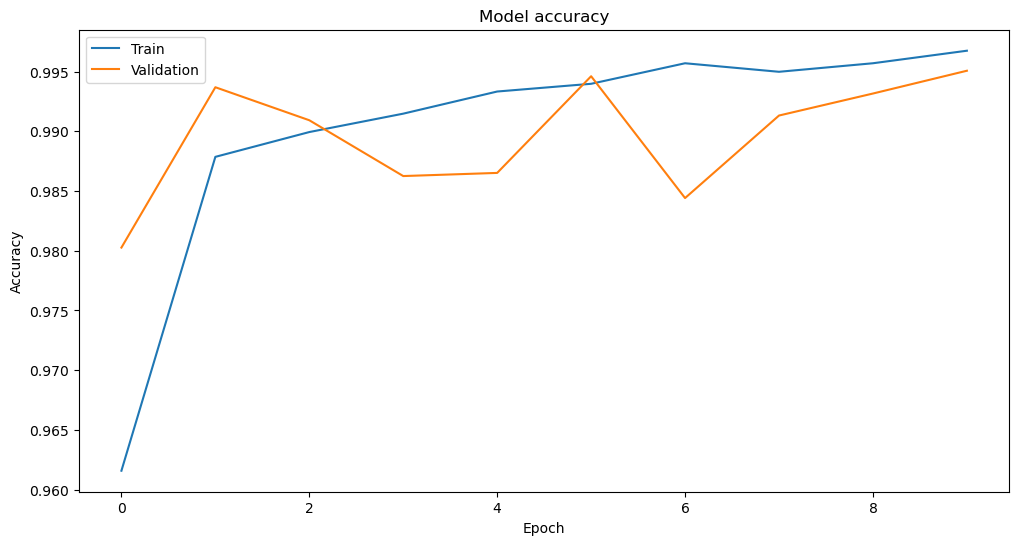

In [8]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
X_test, y_test = None, None
for images, labels in test_data.take(25):
    if X_test == None or y_test == None:
        X_test = images
        y_test = labels
    else:
        X_test = tf.concat([X_test, images], axis = 0)
        y_test = tf.concat([y_test, labels], axis = 0)
        
X_test.shape, y_test.shape

(TensorShape([1600, 256, 256, 3]), TensorShape([1600]))

In [10]:
from sklearn import metrics
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)
metrics.accuracy_score(y_test, y_pred)

50/50 [==============================] - 1s 21ms/step


0.994375

In [11]:
from sklearn.metrics import classification_report
target_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
print(classification_report(y_test , y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Arborio       0.98      1.00      0.99       293
     Basmati       1.00      1.00      1.00       301
      Ipsala       1.00      0.99      1.00       330
     Jasmine       0.99      0.99      0.99       341
   Karacadag       1.00      0.99      1.00       335

    accuracy                           0.99      1600
   macro avg       0.99      0.99      0.99      1600
weighted avg       0.99      0.99      0.99      1600



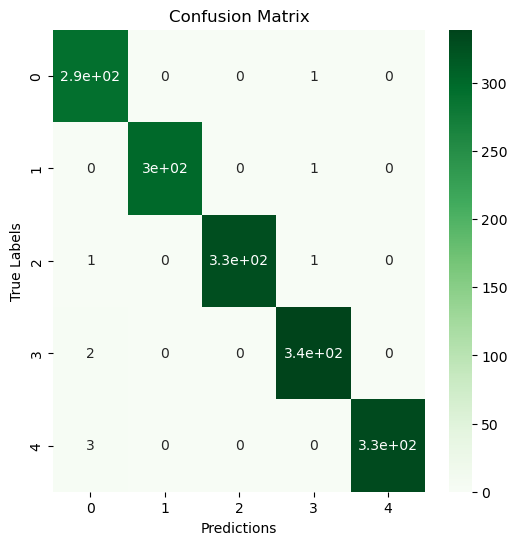

In [12]:
import seaborn as sns
plt.figure(figsize = (6,6), dpi = 100)
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot = True, cmap = 'Greens')
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

2/2 [==============================] - 0s 16ms/step


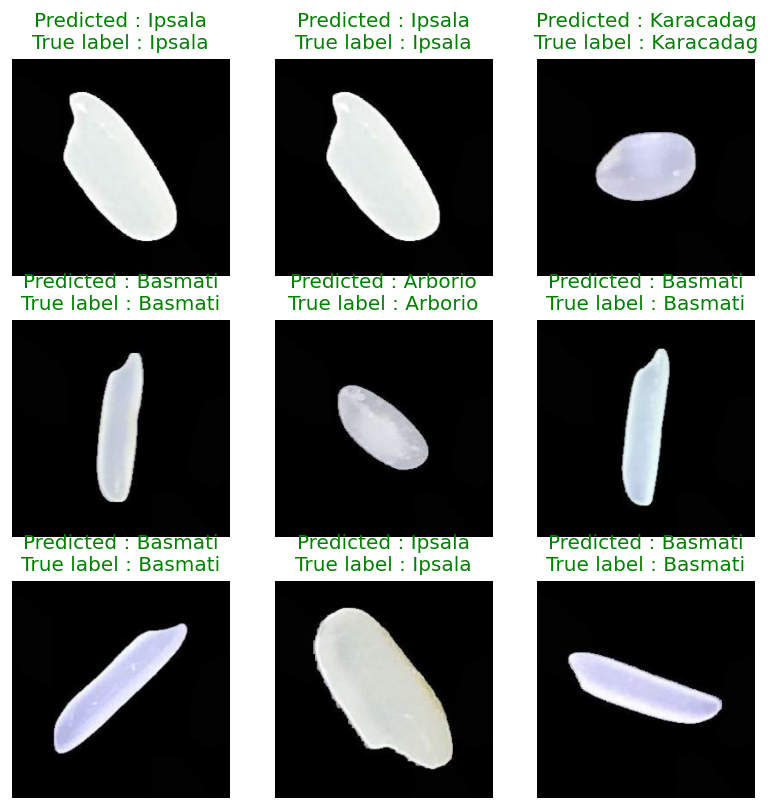

In [61]:
# plot random images from a given dataset, and compare predictions with ground truth
def plot_random_predictions(dataset, model):

    shuffled_data = dataset.shuffle(10)
    class_names = dataset.class_names

    for images, labels in shuffled_data.take(1):
        plt.figure(figsize = (8, 8), dpi = 120)
        y_pred_proba = model.predict(images)

    for i in range(9):
        index = random.randint(0, len(images))
        ax = plt.subplot(3,3, i + 1)

        img = images[index].numpy().astype("uint8")
        y_true = class_names[labels[index]]
        y_pred = class_names[np.argmax(y_pred_proba[index], axis = 0)]
      
        c = 'g' if y_pred == y_true else 'r'
      
        plt.imshow(img)
        plt.title(f'Predicted : {y_pred}\nTrue label : {y_true}', c = c)
        plt.axis(False)
        
plot_random_predictions(test_data, model)